Importing standard libraries (numpy, matplotlib).

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Loading data

In [2]:
#this method seems most robust with loading CSV data
from pandas import read_csv

data=read_csv('multi-label.csv') #load CSV
num_samp=data.shape[0] #first dim -> number of samples in DB
num_feat=data.shape[1] #second dim -> number of features per sample
num_feat-=2 #remove first and last column from count

In [3]:
print 'Nuber of samples: {}'.format(num_samp)
print 'Nuber of features: {}'.format(num_feat)

Nuber of samples: 75
Nuber of features: 97


### Converting data for classification

We need two matrices:

  * input matrix - dimensions [num_samp x num_feat]
  * output matrix - dimensions [num_samp x num_cls]

In [4]:
inp=data.ix[:,1:-1].as_matrix() #extract all values, except first (file name) and last (class)
out_str=data.ix[:,-1].values.tolist() #extract class column only

#convert list of class strings into list-of-lists
out_lstr=[]
for s in out_str:
    out_lstr.append(s.split('+')) #split each string on '+' sign

cls=sorted(set([i for j in out_lstr for i in j])) #sort and uniq all elements of the above list-of-lists
num_cls=len(cls) #calculate number of classes
cls_ind=dict(zip(cls,range(num_cls))) #create a map between class name -> class index

#create a binary matrix of multilable classes
out=np.zeros((num_samp,num_cls))
for si in range(num_samp):
    for c in out_lstr[si]:
        out[si,cls_ind[c]]=1

# Keras model

This is a little GUI component to display a progress bar in Notebook.

In [5]:
from ipywidgets import IntProgress, HTML, VBox
from IPython.display import display, SVG
from keras.callbacks import Callback

class NotebookProgress(Callback):
    def on_train_begin(self, logs={}):
        self.nb_epoch = self.params['nb_epoch']
        self.progbar = IntProgress(min=0, max=self.nb_epoch, value=0)
        self.label = HTML()
        self.box = VBox(children=[self.progbar,self.label])
        display(self.box)

    def on_epoch_end(self, epoch, logs={}):                
        self.progbar.value=epoch
        self.label.value='Epoch {}/{}'.format(epoch,self.nb_epoch)
        
    def on_train_end(self,logs={}):
        self.box.close()

Using TensorFlow backend.


Here we define a simple model using Keras. It can easily be extended to any number of layers.

In [6]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

feat_num=inp.shape[1]
cls_num=out.shape[1]

def make_model():
    
    #base class for most models in Keras
    model = Sequential()

    #this is a single layer model, ie. logistic regression
#     model.add(Dense(input_dim=feat_num,output_dim=cls_num))

    #this is a model with one hidden layer with 250 units
    model.add(Dense(input_dim=feat_num,output_dim=250))
    model.add(Dense(output_dim=cls_num))

    #stochastic gradient descent optimizer with fairly low learning rate and no other params
    sgd=SGD(lr=1e-6, momentum=0, decay=0, nesterov=False)

    #main compilation method
    #we use x-entropy loss function
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
    return model

We can also visualize the model using graph:

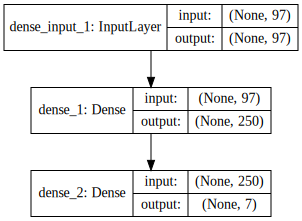

In [7]:
from keras.utils.visualize_util import model_to_dot

SVG(model_to_dot(make_model(),show_shapes=True).create(prog='dot', format='svg'))

This method is used to perform one full training run of the network. We use a constant number of epochs. If we had a validation set, we could also check and save only the best result per run, but here we save the last only.

In [8]:
epoch_num=100

def run(inp, out, tr_idx, tst_idx):
    
        #always recreate the model - in order to get a completely new network
        model=make_model()
        
        #model training
        history = model.fit(inp[tr_idx],out[tr_idx],batch_size=1, verbose=0, nb_epoch=epoch_num, callbacks=[NotebookProgress()])
        
        #model evaulation
        metrics = model.evaluate(inp[tst_idx],out[tst_idx], batch_size=1, verbose=0)
        
        return metrics,history

This is a demonstration of how to use the above method.

In [9]:
all=range(inp.shape[0]) #list of all data indices
p=int(0.9*len(all)) #point at 90% of data
tr_idx=all[:p] #indices 0-90% are training
tst_idx=all[p:] #last 10% is test

#do one training run
metrics,history=run(inp,out,tr_idx,tst_idx)

print 'LOSS: {} ACC: {:%}'.format(metrics[0],metrics[1])

LOSS: 1.90157290455 ACC: 0.000000%


Here we draw the history of training of one full run.

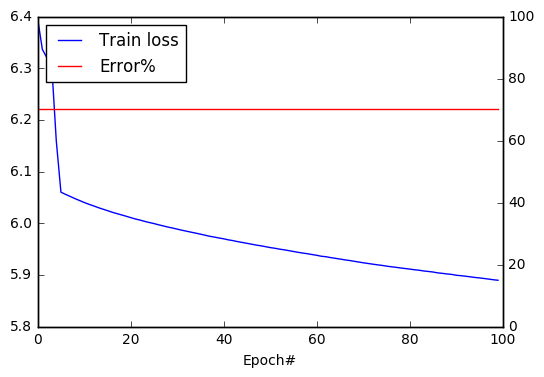

In [10]:
loss=np.array(history.history['loss'])
acc=np.array(history.history['acc'])

p1=plot(loss,label='Train loss')
xlabel('Epoch#')
ax=twinx()
p2=ax.plot(100*(1-acc),'r',label='Error%')
ax.set_ylim(0,100)

lines = [p1[0], p2[0]]
legend(lines, [l.get_label() for l in lines],loc='upper left')

## Cross validation

Here we make a method for doing cross validation.

In [11]:
from random import shuffle

def cv(n_folds, inp, out):
    
    all_idx=range(inp.shape[0]) #prepare a list of all indices
    shuffle(all_idx) #shuffle the list
    
    fold_len=len(all_idx)/n_folds #number of items in one fold
    
    #make a list of folds - each fold is a list of indices
    folds=[]
    for i in range(n_folds):
        folds.append(all_idx[fold_len*i:fold_len*(i+1)])
    if n_folds*fold_len<len(all_idx):
        folds[-1].extend(all_idx[n_folds*fold_len:])
    
    #compute acc for all folds
    acc=[]
    for fold_idx in range(n_folds):
        
        #make train/test index lists for currrent fold
        tst_idx=folds[fold_idx]
        tr_idx=[]
        for i in range(n_folds):
            if i != fold_idx:
                tr_idx.extend(folds[i])
            
        #do the run
        met,hist = run(inp,out,tr_idx,tst_idx)
        
        print 'Fold {}/{} -> {:%}'.format(fold_idx+1,n_folds,met[1])
        
        acc.append(met[1])
        
    return np.array(acc)

Perform actual 5-fold CV and compute the average accuracy.

In [12]:
acc=cv(5,inp,out)
print 'Average CV ACC: {:%}'.format(acc.mean())

Fold 1/5 -> 20.000000%
Fold 2/5 -> 6.666667%
Fold 3/5 -> 6.666667%
Fold 4/5 -> 33.333333%
Fold 5/5 -> 6.666667%
Average CV ACC: 14.666667%
